#### Бібліотеки

In [13]:
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import label_binarize
import gradio as gr

c:\Users\Андрій\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Онтологія

In [ ]:
BASE_DIR ="C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"

ontology = {"MilitaryVehicle": {}}

for category in os.listdir(BASE_DIR):
    category_path = os.path.join(BASE_DIR, category)
    if not os.path.isdir(category_path):
        continue

    ontology["MilitaryVehicle"][category] = {}

    for subfolder in os.listdir(category_path):
        subfolder_path = os.path.join(category_path, subfolder)
        if os.path.isdir(subfolder_path):
            images = [
                f for f in os.listdir(subfolder_path)
                if f.lower().endswith((".jpg", ".png", ".jpeg"))
            ]
            ontology["MilitaryVehicle"][category][subfolder] = images

output_path = os.path.join(BASE_DIR, "ontology.json")
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(ontology, f, indent=4, ensure_ascii=False)



print(f"Файл ontology.json створено в {output_path}")


<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Андрій\AppData\Local\Temp\ipykernel_5744\3995294748.py:4: SyntaxWarning: invalid escape sequence '\A'
  BASE_DIR ="C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"


Файл ontology.json створено в C:\Andriy\Practice\Dataset\ExtructedFramesextended\images\ontology.json


In [ ]:
DATA_DIR = r"C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32
)

print("Класи знайдені:", train_ds.class_names)


Found 112318 files belonging to 4 classes.
Using 89855 files for training.
Found 112318 files belonging to 4 classes.
Using 22463 files for validation.
Класи знайдені: ['BMP', 'Bradley', 'Tank', 'unknown']


#### Перевірка на фото

In [ ]:
DATA_DIR = r"C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"
MODEL_PATH = "mobilenetv2_military_final.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


classes = sorted(os.listdir(DATA_DIR)) 

model = models.mobilenet_v2(pretrained=False)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(classes))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

all_images = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith((".jpg", ".png", ".jpeg")):
            all_images.append(os.path.join(root, f))

sample_images = random.sample(all_images, 15)

with torch.no_grad():
    for img_path in sample_images:
        img = Image.open(img_path).convert("RGB")
        tensor = transform(img).unsqueeze(0).to(DEVICE)

        outputs = model(tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        pred_class = classes[pred_idx]

        print(f"Файл: {img_path}")
        print(f"Прогноз: {pred_class}")
        print("Ймовірності по класах:")
        for cls, p in zip(classes, probs.cpu().numpy()):
            print(f"  {cls}: {p:.4f}")
        print("-" * 40)


C:\Users\Андрій\AppData\Local\Temp\ipykernel_5556\4124140189.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

Файл: C:\Andriy\Practice\Dataset\ExtructedFramesextended\images\Tank\20240921222736\frame_00944.jpg
Прогноз: Tank
Ймовірності по класах:
  BMP: 0.0000
  Bradley: 0.0000
  Tank: 1.0000
  unknown: 0.0000
----------------------------------------
Файл: C:\Andriy\Practice\Dataset\ExtructedFramesextended\images\Tank\20240921193855\frame_00859.jpg
Прогноз: Tank
Ймовірності по класах:
  BMP: 0.0005
  Bradley: 0.0001
  Tank: 0.9994
  unknown: 0.0001
----------------------------------------
Файл: C:\Andriy\Practice\Dataset\ExtructedFramesextended\images\BMP\20240920234738\frame_00142.jpg
Прогноз: BMP
Ймовірності по класах:
  BMP: 1.0000
  Bradley: 0.0000
  Tank: 0.0000
  unknown: 0.0000
----------------------------------------
Файл: C:\Andriy\Practice\Dataset\ExtructedFramesextended\images\BMP\20240920234658\frame_00087.jpg
Прогноз: BMP
Ймовірності по класах:
  BMP: 1.0000
  Bradley: 0.0000
  Tank: 0.0000
  unknown: 0.0000
----------------------------------------
Файл: C:\Andriy\Practice\Dataset

#### Модель TensorFlow з графіками основних метрик

Found 112318 files belonging to 4 classes.
Using 89855 files for training.
Found 112318 files belonging to 4 classes.
Using 22463 files for validation.
Класи: ['BMP', 'Bradley', 'Tank', 'unknown']
Epoch 1/5


c:\Users\Андрій\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1404/1404 ━━━━━━━━━━━━━━━━━━━━ 242s 129ms/step - accuracy: 0.7296 - loss: 0.6579 - val_accuracy: 0.8893 - val_loss: 0.2903
Epoch 2/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.8851 - loss: 0.2860 - val_accuracy: 0.9159 - val_loss: 0.2076
Epoch 3/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.9217 - loss: 0.1986 - val_accuracy: 0.9515 - val_loss: 0.1295
Epoch 4/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 54s 39ms/step - accuracy: 0.9418 - loss: 0.1498 - val_accuracy: 0.9606 - val_loss: 0.1036
Epoch 5/5
1404/1404 ━━━━━━━━━━━━━━━━━━━━ 54s 39ms/step - accuracy: 0.9543 - loss: 0.1226 - val_accuracy: 0.9566 - val_loss: 0.1142


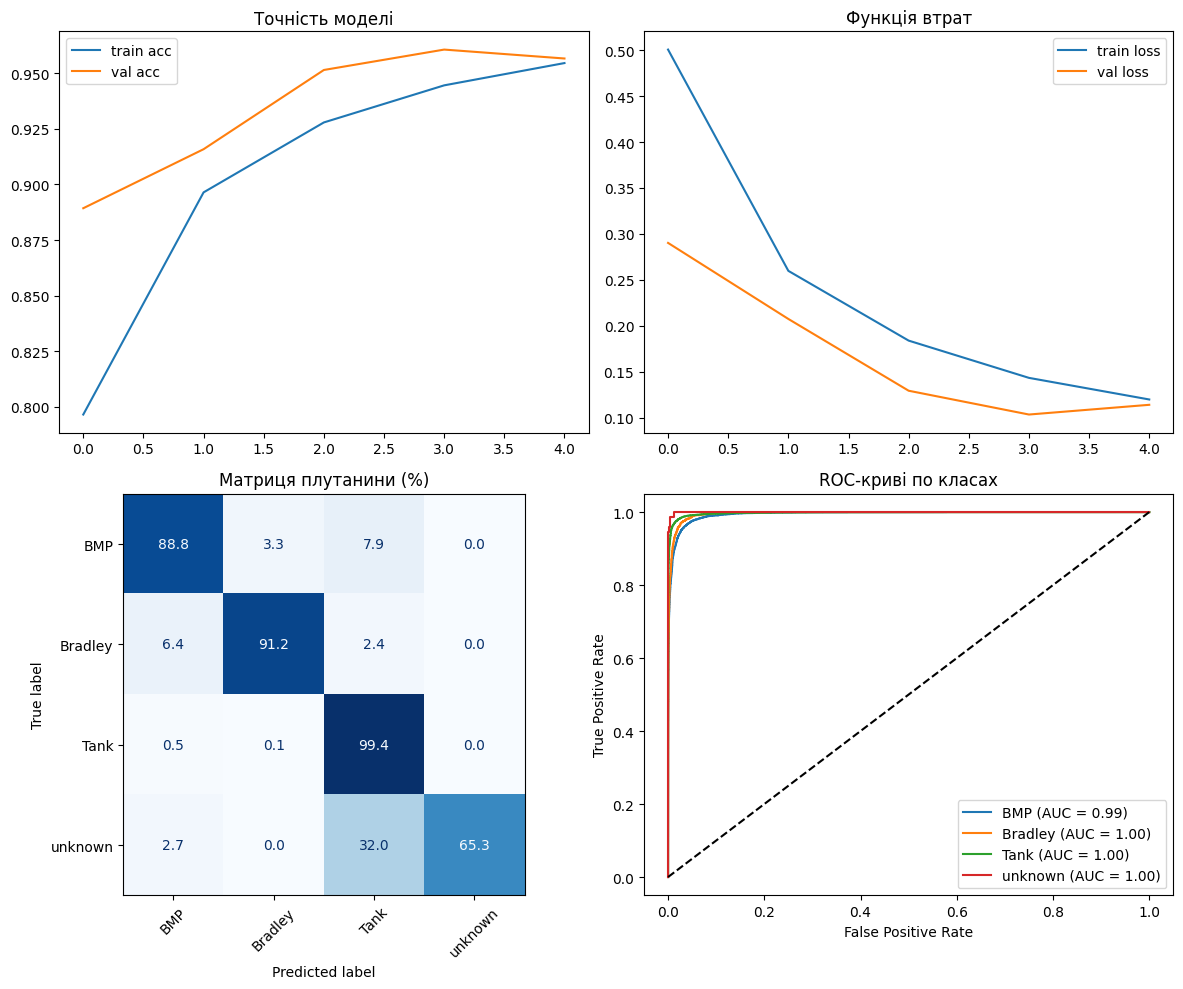

Звіт по класах:


,precision,recall,f1-score,support
BMP,0.966620,0.888037,0.925664,6261.00000
Bradley,0.880174,0.911964,0.895787,1772.00000
Tank,0.962094,0.993661,0.977622,14355.00000
unknown,1.000000,0.653333,0.790323,75.00000
accuracy,0.956640,0.956640,0.956640,0.95664
macro avg,0.952222,0.861749,0.897349,22463.00000
weighted avg,0.957020,0.956640,0.956059,22463.00000


Прогноз: BMP


In [ ]:
DATA_DIR = r"C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(64, 64),
    batch_size=64
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(64, 64),
    batch_size=64
)

class_names = train_ds.class_names
print("Класи:", class_names)

def to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

train_ds = train_ds.map(to_grayscale)
val_ds = val_ds.map(to_grayscale)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(64, 64, 1)),
    layers.Conv2D(16, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

y_true = []
y_pred = []
y_pred_proba = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_proba.extend(preds)

y_pred_proba = np.array(y_pred_proba)

cm = confusion_matrix(y_true, y_pred, normalize="true") * 100

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history.history["accuracy"], label="train acc")
axes[0, 0].plot(history.history["val_accuracy"], label="val acc")
axes[0, 0].set_title("Точність моделі")
axes[0, 0].legend()

axes[0, 1].plot(history.history["loss"], label="train loss")
axes[0, 1].plot(history.history["val_loss"], label="val loss")
axes[0, 1].set_title("Функція втрат")
axes[0, 1].legend()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format=".1f", ax=axes[1, 0], colorbar=False)
axes[1, 0].set_title("Матриця плутанини (%)")

y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

axes[1, 1].plot([0, 1], [0, 1], "k--")
axes[1, 1].set_title("ROC-криві по класах")
axes[1, 1].set_xlabel("False Positive Rate")
axes[1, 1].set_ylabel("True Positive Rate")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("Звіт по класах:")
report_dict = classification_report(
    y_true, y_pred, target_names=class_names, digits=3, output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()
display(report_df)

model.save("vehicle_classifier_fast.h5")

test_img = r"C:\Andriy\Practice\Dataset\ExtructedFramesextended\images\BMP\20240921011625\frame_00000.jpg"
img = Image.open(test_img).convert("L").resize((64, 64))  
img_array = np.array(img)
img_array = np.expand_dims(img_array, -1)   
img_array = tf.expand_dims(img_array, 0)   

predictions = model.predict(img_array, verbose=0)
pred_class = class_names[np.argmax(predictions)]
print("Прогноз:", pred_class)


### MobileNetV2(1 епоха, 87%)

#### Створення моделі

In [ ]:
DATA_DIR = r"C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"
BATCH_SIZE = 32
EPOCHS = 1
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 0 if os.name == "nt" else 4  # Windows часто крашиться з >0

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_targets = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]
class_counts = Counter(train_targets)
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_targets]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(dataset.classes))

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "mobilenetv2_military.pth")
print("Модель збережено!")


c:\Users\Андрій\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Андрій\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1] Train Loss: 0.4562, Train Acc: 82.39% Val Loss: 0.3443, Val Acc: 86.98%
Модель збережено!


#### Метрики

C:\Users\Андрій\AppData\Local\Temp\ipykernel_5556\2587749938.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

              precision    recall  f1-score   support

         BMP       0.80      0.82      0.81     30556
     Bradley       0.61      0.87      0.72      9115
        Tank       0.96      0.89      0.92     72267
     unknown       0.51      1.00      0.68       380

    accuracy                           0.87    112318
   macro avg       0.72      0.89      0.78    112318
weighted avg       0.88      0.87      0.87    112318



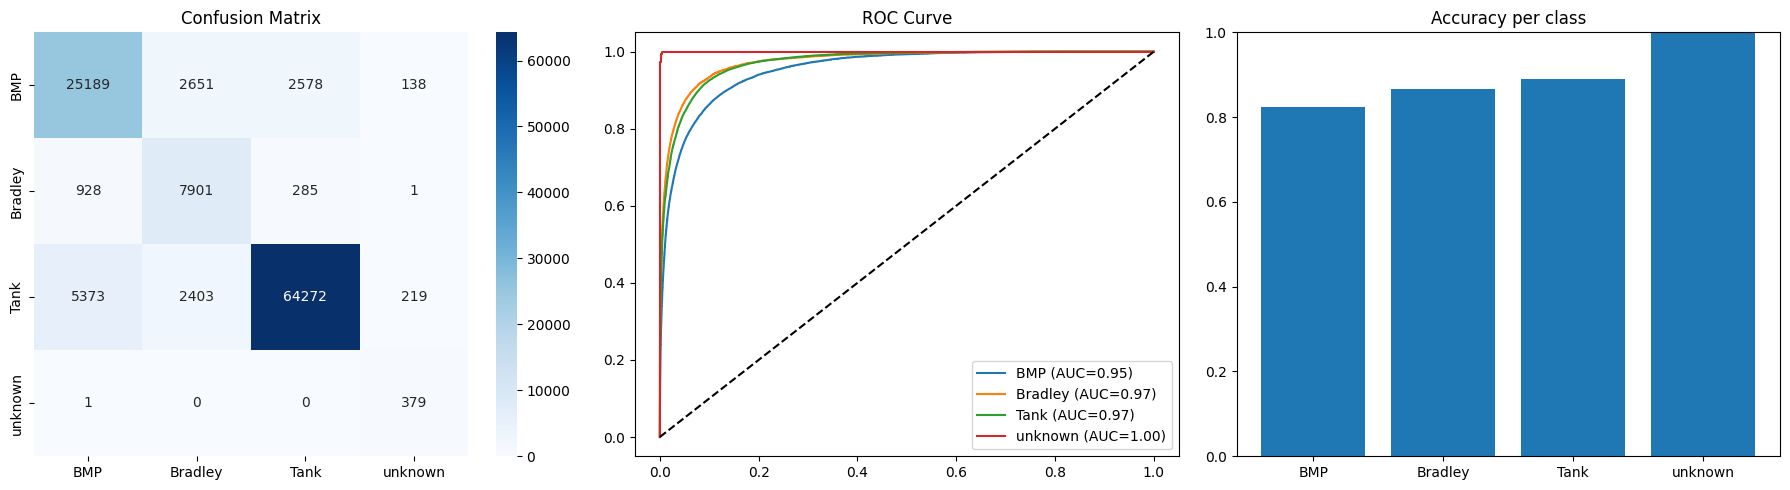

In [ ]:

# === Конфігурація ===
DATA_DIR = r"C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"
MODEL_PATH = "mobilenetv2_military.pth"
DEVICE = torch.device("cpu")

# === Завантажуємо дані ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
classes = test_dataset.classes

# === Модель ===
model = models.mobilenet_v2(weights=None)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(classes))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# === Прогноз ===
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

# === Звіт ===
print(classification_report(y_true, y_pred, target_names=classes))

# === Малювання ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=axs[0])
axs[0].set_title("Confusion Matrix")

# ROC Curve
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, label=f"{classes[i]} (AUC={roc_auc:.2f})")

axs[1].plot([0, 1], [0, 1], "k--")
axs[1].set_title("ROC Curve")
axs[1].legend()

# Bar chart Accuracy
acc_per_class = cm.diagonal() / cm.sum(axis=1)
axs[2].bar(classes, acc_per_class)
axs[2].set_ylim(0, 1)
axs[2].set_title("Accuracy per class")

plt.tight_layout()
plt.show()


### MobileNetV2(2 епохи, 94%)

#### Створення моделі

In [ ]:
DATA_DIR = r"C:\Andriy\Practice\Dataset\ExtructedFramesextended\images"
BATCH_SIZE = 64           
EPOCHS = 3               
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4 if os.name != "nt" else 0

torch.set_num_threads(8)
torch.backends.mkldnn.enabled = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform  # валід. без augmentation


train_targets = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]
class_counts = Counter(train_targets)
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_targets]

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


model = models.mobilenet_v2(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.features[14:].parameters():
    param.requires_grad = True

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(dataset.classes))
model = model.to(DEVICE)

class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(dataset.classes))], dtype=torch.float).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=1, factor=0.5, verbose=True)

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.inference_mode():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss/total:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "mobilenetv2_military_final.pth")
print("Модель збережено!")


c:\Users\Андрій\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Андрій\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Андрій\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/3] Train Loss: 0.0105, Train Acc: 93.09% Val Loss: 0.1925, Val Acc: 89.39%
Epoch [2/3] Train Loss: 0.0029, Train Acc: 97.70% Val Loss: 0.0470, Val Acc: 97.60%
Epoch [3/3] Train Loss: 0.0016, Train Acc: 98.75% Val Loss: 0.1221, Val Acc: 94.59%
Модель збережено!


#### Метрики


Classification Report:

              precision    recall  f1-score   support

         BMP       0.99      0.96      0.97      6076
     Bradley       0.65      1.00      0.79      1845
        Tank       0.99      0.93      0.96     14474
     unknown       0.88      1.00      0.94        69

    accuracy                           0.95     22464
   macro avg       0.88      0.97      0.91     22464
weighted avg       0.96      0.95      0.95     22464



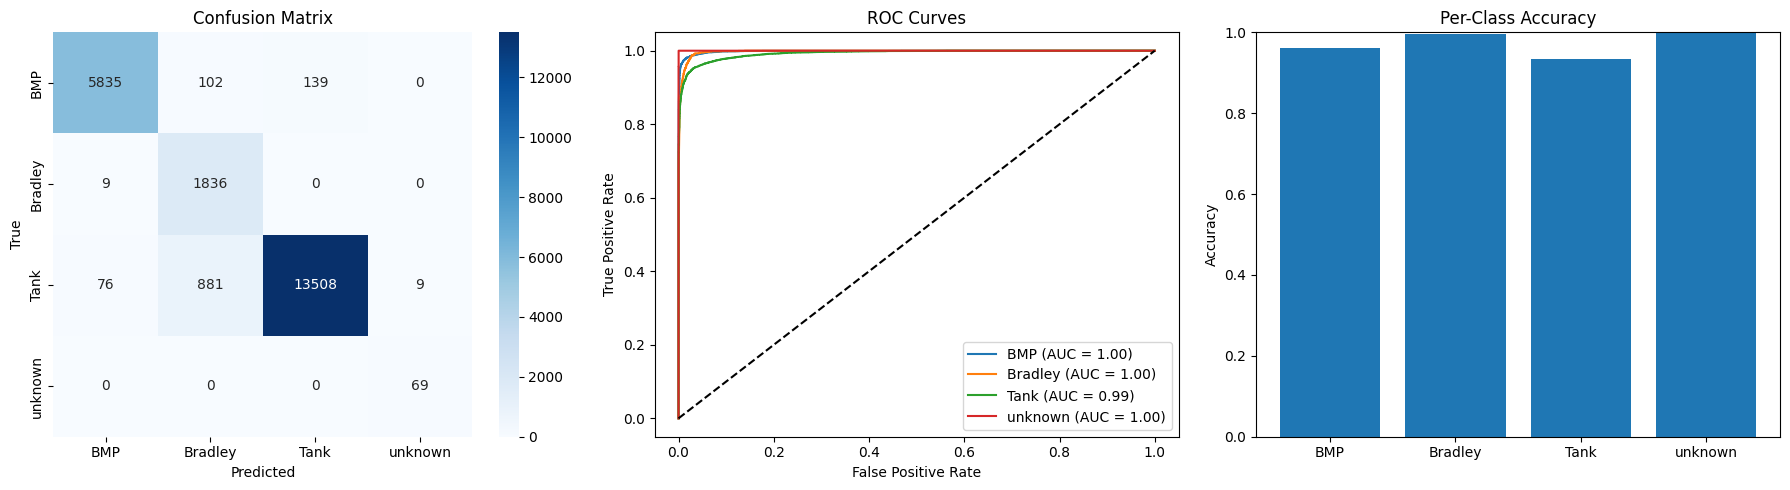

In [ ]:
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.inference_mode():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes, ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

y_true_bin = label_binarize(all_labels, classes=list(range(len(dataset.classes))))
for i in range(len(dataset.classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"{dataset.classes[i]} (AUC = {roc_auc:.2f})")
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title("ROC Curves")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

class_acc = cm.diagonal() / cm.sum(axis=1)
axes[2].bar(dataset.classes, class_acc)
axes[2].set_title("Per-Class Accuracy")
axes[2].set_ylim([0, 1])
axes[2].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


#### Перевірка з фото та фінальною моделлю в Gradio

In [14]:
MODEL_PATH = "mobilenetv2_military_final.pth"
DEVICE = torch.device("cpu")
classes = ["BMP", "Bradley", "Tank", "Unknown"]

model = models.mobilenet_v2(weights=None)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(classes))
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def predict(image):
    image = Image.fromarray(image).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

    return {classes[i]: float(probs[i]) for i in range(len(classes))}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=4),
    title="Військовий об'єкт (MobileNetV2)",
    description="Завантажте фото, і модель покаже, що це за об'єкт"
)

demo.launch()


C:\Users\Андрій\AppData\Local\Temp\ipykernel_5744\43014367.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVI

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
